In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sportran as st
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from scipy.interpolate import CubicSpline, interp1d
def model_scalar(x, y):
    return CubicSpline(np.concatenate([-x[::-1], x[1:]]), np.concatenate([y[::-1], y[1:]]))

n = 2
def model_wishart_(x, y):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    y00, y01, y11 = y.reshape(3,l)
    yy = np.array([[y00, y01], [np.zeros_like(y01), y11]]).T
    # yy = np.einsum('tab,tbc->tac', np.transpose(yy, axes=(0,2,1)), yy)
    yy = np.concatenate([yy[::-1], yy[1:]])
    # return interp1d(xx, yy)) 
    return CubicSpline(xx, yy) #, bc_type = 'clamped')

import numpy as np
from scipy.interpolate import CubicSpline

def model_wishart(x, y, N):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    upper_triangle_indices = np.triu_indices(N)
    y_elements = y.reshape(len(upper_triangle_indices[0]), l)
    
    yy = np.zeros((l, N, N))
    for k, (i, j) in enumerate(zip(*upper_triangle_indices)):
        yy[:, j, i] = y_elements[k]
    
    yy = np.concatenate([yy[::-1], yy[1:]])
    return CubicSpline(xx, yy)


In [4]:
dc=np.load('data/bayesian/CsF/dc_minimal.npy', allow_pickle = True).item()

In [5]:
flux = st.HeatCurrent([
    dc['qflux'],
    dc['ele_flux']
    ],
    DT_FS=1,
    TEMPERATURE=dc['Temeprature'],
    VOLUME=dc['Volume'],
    UNITS='metal')

Using multicomponent code.


In [90]:
flux_resample=flux.resample(fstar_THz=20)

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     500.00000 THz
 Resampling freq          f* =      20.00000 THz
 Sampling time         TSKIP =            25 steps
                             =        25.000 fs
 Original  n. of frequencies =        100001
 Resampled n. of frequencies =          4001
 min(PSD)          (pre-filter&sample) =      0.00000
 min(PSD)         (post-filter&sample) =      0.00018
 % of original PSD Power f<f* (pre-filter&sample)  = 99.707 %
 fPSD not calculated before resampling
 -----------------------------------------------------



# Diagonal (thermal)

In [237]:
flux_resample.maxlike_estimate(model_scalar, n_parameters='AIC', likelihood='chisquare', solver='BFGS')

MaxLikeFilter
Optimal number of parameters between 3 and 40 chosen by AIC
n_parameters = 3
(3,)
n_parameters = 4
(4,)
n_parameters = 5
(5,)
n_parameters = 6
(6,)
n_parameters = 7
(7,)
n_parameters = 8
(8,)
n_parameters = 9
(9,)
n_parameters = 10
(10,)
n_parameters = 11
(11,)
n_parameters = 12
(12,)
n_parameters = 13
(13,)
n_parameters = 14
(14,)
n_parameters = 15
(15,)
n_parameters = 16
(16,)
n_parameters = 17
(17,)
n_parameters = 18
(18,)
n_parameters = 19
(19,)
n_parameters = 20
(20,)
n_parameters = 21
(21,)
n_parameters = 22
(22,)
n_parameters = 23
(23,)
n_parameters = 24
(24,)
n_parameters = 25
(25,)
n_parameters = 26
(26,)
n_parameters = 27
(27,)
n_parameters = 28
(28,)
n_parameters = 29
(29,)
n_parameters = 30
(30,)
n_parameters = 31
(31,)
n_parameters = 32
(32,)
n_parameters = 33
(33,)
n_parameters = 34
(34,)
n_parameters = 35
(35,)
n_parameters = 36
(36,)
n_parameters = 37
(37,)
n_parameters = 38
(38,)
n_parameters = 39
(39,)


In [238]:
flux_resample.maxlike.optimizer_res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 4607.49463640278
        x: [ 6.505e-01  4.867e-01  4.202e-01  2.312e-01  1.215e-01
             5.103e-02  1.880e-02  7.348e-03  2.915e-03]
      nit: 18
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.221e-04
            -3.662e-04  9.766e-04 -1.343e-03 -6.714e-04]
 hess_inv: [[ 9.926e-04 -4.920e-06 ...  5.006e-08 -9.160e-08]
            [-4.920e-06  4.359e-05 ... -1.469e-07 -1.407e-07]
            ...
            [ 5.006e-08 -1.469e-07 ...  5.283e-08 -1.296e-08]
            [-9.160e-08 -1.407e-07 ... -1.296e-08  9.298e-08]]
     nfev: 290
     njev: 29

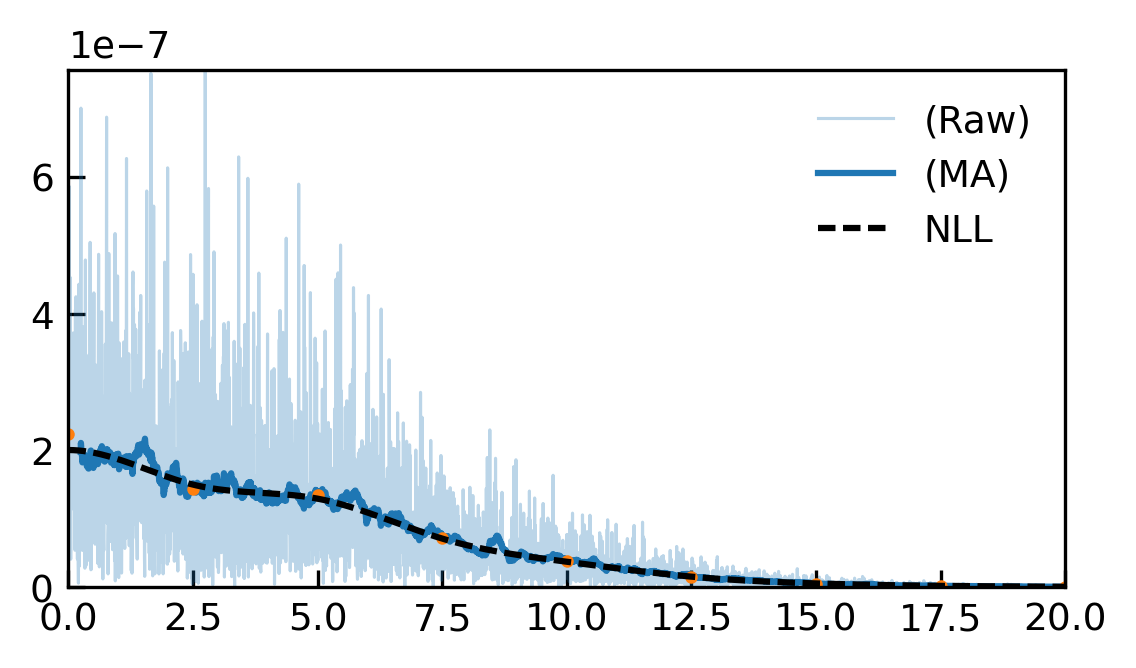

In [242]:
omega = flux_resample.maxlike.omega
data_chisquare = flux_resample.maxlike.data
estimate = flux_resample.NLL_spline(omega)
estimate_p = flux_resample.NLL_spline_upper(omega)
estimate_m = flux_resample.NLL_spline_lower(omega)

ip = 0
addaxes = []

N = data_chisquare.shape[-1]
fs = plt.rcParams['figure.figsize']

fig, ax = plt.subplots()

pl, = ax.plot(flux_resample.freqs_THz, 
                data_chisquare*flux_resample.KAPPA_SCALE/2, 
                alpha = 0.3, 
                label = f'(Raw)',
        )

ax.plot(flux_resample.freqs_THz, 
        pd.Series(data_chisquare).rolling(window=50).mean()*flux_resample.KAPPA_SCALE/2, 
        alpha = 1, 
        label = f'(MA)', 
        lw = 1.5,
        color = pl.get_color()
        )

x = flux_resample.freqs_THz[flux_resample.maxlike.omega_fixed]
y = flux_resample.maxlike._guess_data*flux_resample.KAPPA_SCALE/2
ax.plot(x, y, 'o')

ymin, ymax = ax.get_ylim()

x, y = flux_resample.freqs_THz, estimate*flux_resample.KAPPA_SCALE/2
ym, yp = estimate_m*flux_resample.KAPPA_SCALE/2, estimate_p*flux_resample.KAPPA_SCALE/2

ax.plot(x, 
        y, 
        color = 'k',
        lw = 1.5,
        label = 'NLL',
        ls = '--')
        
# ax.fill_between(x, 
#                 ym, 
#                 yp, 
#                 color = 'k', 
#                 alpha = 0.5)
        
# # ax.set_xlim(0,10)
ax.set_ylim(0,ymax)
# ax.set_xlabel('$\omega/2\pi$ (THz)')

ax.legend()

fig.tight_layout()

# Off-diagonal (Seebeck)

# Wishart

In [44]:
flux_resample.maxlike_estimate(lambda x, y: model_wishart(x, y, 2), list(range(3, 15)))

MaxLikeFilter
Optimal number of parameters between 3 and 14 chosen by AIC
n_parameters = 3
n_parameters = 4
n_parameters = 5
n_parameters = 6
n_parameters = 7
n_parameters = 8
n_parameters = 9
n_parameters = 10
n_parameters = 11
n_parameters = 12
n_parameters = 13
n_parameters = 14


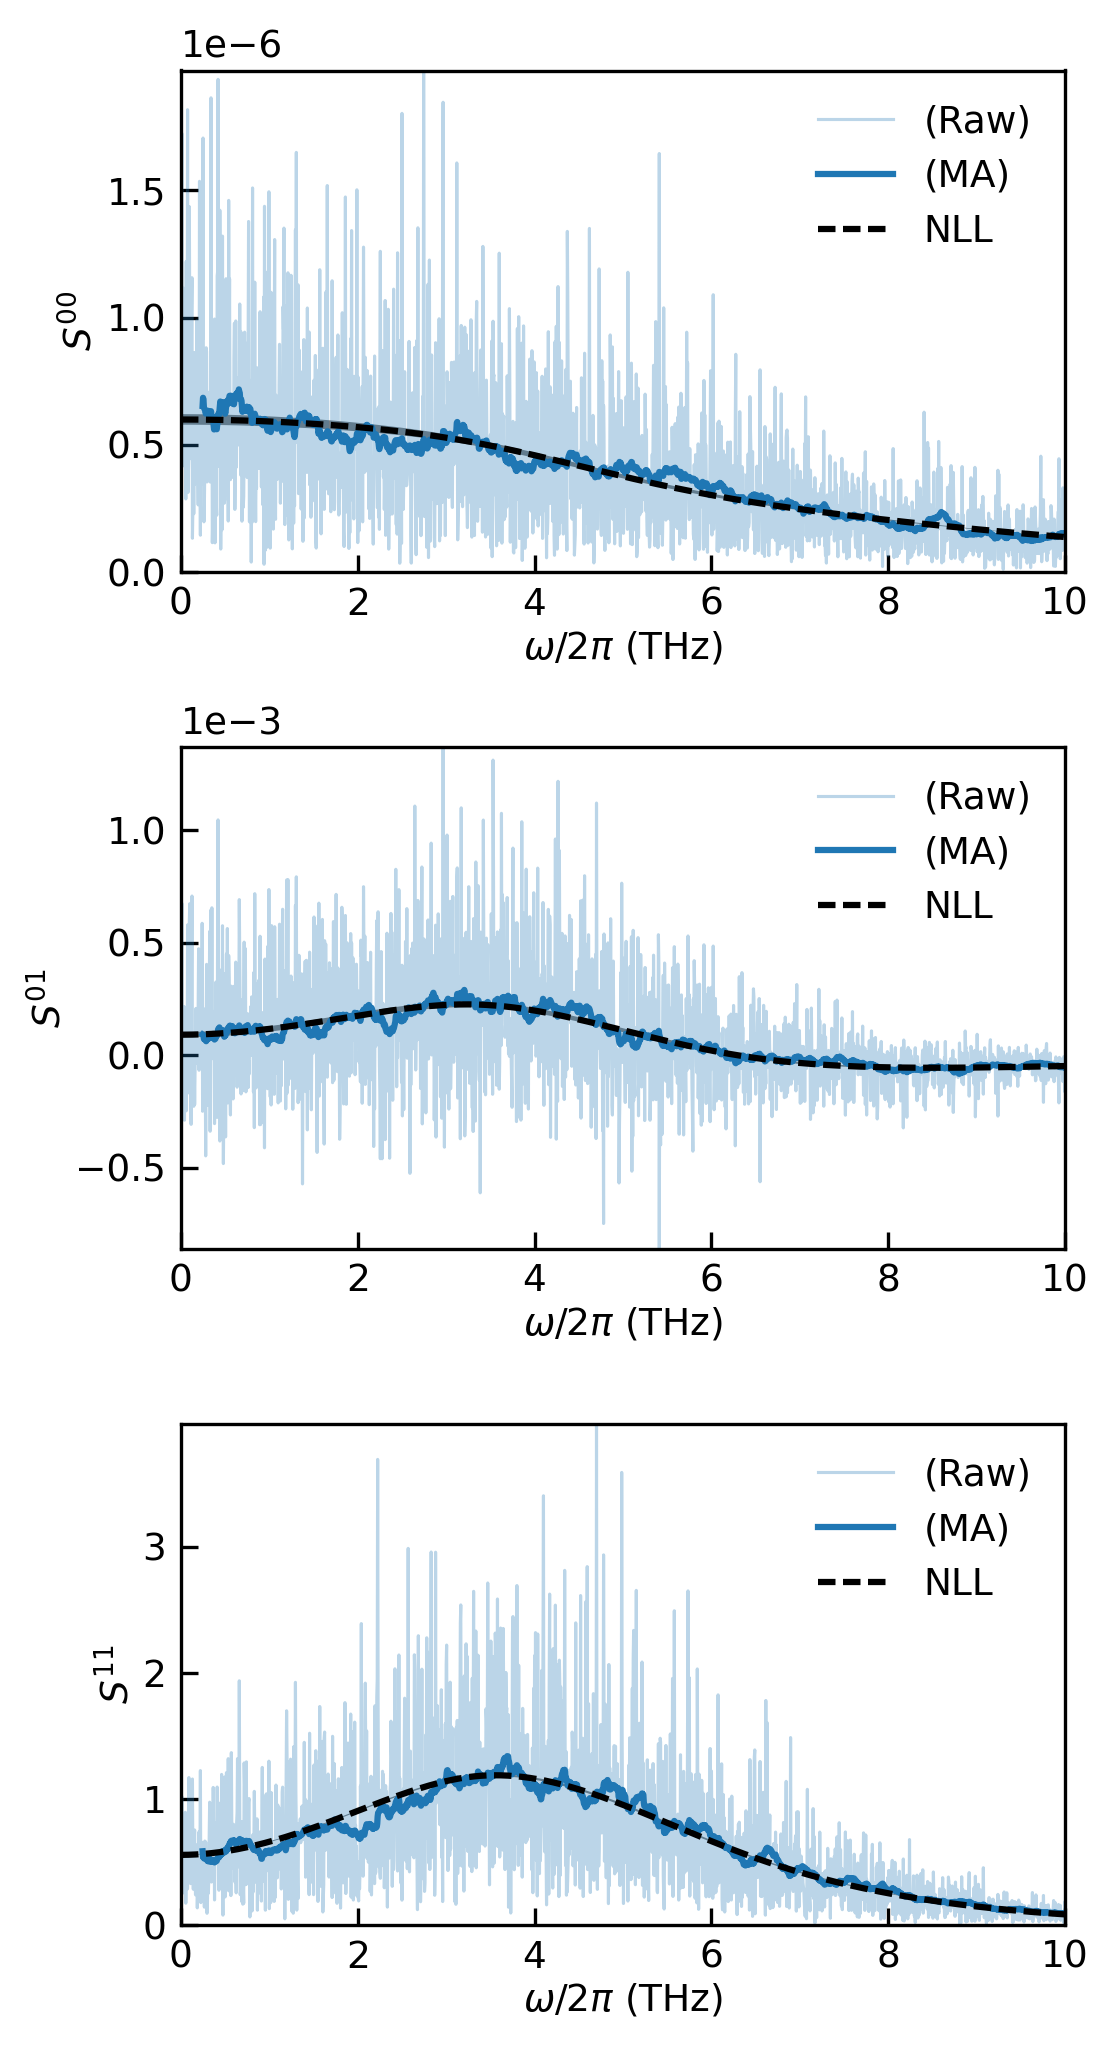

In [43]:
omega = flux_resample.maxlike.omega
data_wishart = flux_resample.maxlike.data
estimate = flux_resample.NLL_spline(omega)
estimate_p = flux_resample.NLL_spline_upper(omega)
estimate_m = flux_resample.NLL_spline_lower(omega)

ip = 0
addaxes = []

N = data_wishart.shape[-1]
fs = plt.rcParams['figure.figsize']

fig, axes = plt.subplots(nrows = N*(N+1)//2, ncols = 1, figsize = (fs[0], 3*fs[1]))

for ax, i, j in zip(axes, *np.triu_indices(2)):

        pl, = ax.plot(flux_resample.freqs_THz, 
                        data_wishart[:, i, j]*flux_resample.KAPPA_SCALE/2, 
                        alpha = 0.3, 
                        label = f'(Raw)',
                )

        ax.plot(flux_resample.freqs_THz, 
                pd.Series(data_wishart[:, i, j]).rolling(window=50).mean()*flux_resample.KAPPA_SCALE/2, 
                alpha = 1, 
                label = f'(MA)', 
                lw = 1.5,
                color = pl.get_color()
                )

        x, y = flux_resample.freqs_THz, estimate[:, i, j]*flux_resample.KAPPA_SCALE/2
        ym, yp = estimate_m[:, i, j]*flux_resample.KAPPA_SCALE/2, estimate_p[:, i, j]*flux_resample.KAPPA_SCALE/2

        ax.plot(x, 
                y, 
                color = 'k',
                lw = 1.5,
                label = 'NLL',
                ls = '--')
                
        ax.fill_between(x, 
                        ym, 
                        yp, 
                        color = 'k', 
                        alpha = 0.5)
                
        ax.set_xlim(0,10)
        ax.set_ylim(0 if i == j else None)
        
        ax.set_xlabel('$\omega/2\pi$ (THz)')
        ax.set_ylabel(f'$S^{{{i}{j}}}$')

        ax.legend()

fig.tight_layout()